<a href="https://colab.research.google.com/github/neetmadann/neetmadan.github.io/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data Preprocessing, ESDA and Machine Learning Model

## Import All Packages

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import numpy as np
import os 
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import ensemble
from sklearn.linear_model import Lasso,Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import osmnx as ox
import plotly
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import geopandas as gpd
import numpy as np
import os 

import plotly
import plotly.io as pio # to import to show plotly graph
pio.renderers.default='notebook' #import to show plotly graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("white")
%matplotlib inline


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import ensemble
from sklearn.linear_model import Lasso,Ridge
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.precision", 4) #Limit display of decimal points

In [ ]:
sns.set_palette("tab10", n_colors=None, desat=None, color_codes=False)

## Area Mapping

In [ ]:
eng_area = pd.read_excel('area_final.xlsx')
eng_area = eng_area.drop(['Unnamed: 0'],axis=1)
#{column: len(eng_area[column].unique()) for column in eng_area.columns}
#eng_area.head()
#eng_area.info(null_counts=True)
eng_area = eng_area.drop({'TCITY15CD','TCITY15NM'},axis=1)

##### Map Data

In [ ]:
MSOA = gpd.read_file('MSOA.geojson')
#MSOA.set_crs('EPSG:27700', allow_override=False)
#MSOA.head()
MSOA = MSOA[MSOA['MSOA11CD'].str[0] =='E']
len(MSOA)

6791

<AxesSubplot: >

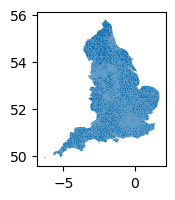

In [ ]:
MSOA.plot(figsize=(2, 2),linewidth=0.01)

## Car ownership Preprocessing
### DFT 2022

In [ ]:
cars = pd.read_csv('car by lsoa.csv',low_memory=False)#specify low memory type false for dtypes of year with mixed data types

cars = cars[cars['LicenceStatus']=='Licensed'] #filter for just licensed cars to be used on roads
cars = cars[cars['BodyType']=='Cars'] #limit to just cars by licensed ownership in England

cars = cars.drop(['BodyType', 'LicenceStatus'],axis=1) #drop unnecessary columns that have been filtered
cars = pd.melt(cars, id_vars=['LSOA11CD', 'LSOA11NM'], var_name='Year-Quarter', value_name='cars') #melt year columns into rows
cars['Year'] = cars['Year-Quarter'].str[0:4] #create Year column
cars['Quarter'] = cars['Year-Quarter'].str[5:7] #create Quarter column
cars = cars[cars['Quarter'].isin(['Q2','Q4'])] #Filter Quarters required
cars = cars.loc[(cars['Year-Quarter'].str.endswith('Q4')) | (cars['Year-Quarter']=='2022 Q2')] #filter for latest data for each year
cars['Year-Quarter'].unique() # check that year quarter chosen is accurate

cols = ['Year', 'cars']
cars[cols] = cars[cols].apply(pd.to_numeric, errors='coerce', axis=1) #change data types for numeric remove errors
cars = cars[['LSOA11CD','LSOA11NM','Year','Quarter','cars']] #keep required columns
cars['Area'] = cars['LSOA11CD'].str[0:2]
cars.loc[cars['LSOA11CD'].str.startswith('E0',na=False),'Country']='England'
cars.loc[cars['LSOA11CD'].str.startswith('95',na=False),'Country'] = 'Northern Ireland'
cars.loc[cars['LSOA11CD'].str.startswith('S0',na=False),'Country'] = 'Scotland'
cars.loc[cars['LSOA11CD'].str.startswith('W0',na=False),'Country'] = 'Wales'
cars.loc[cars['LSOA11CD'].str.startswith('Mi',na=False),'Country'] = 'Other'

##### Exploratory Car Ownership Analysis in United Kingdom, Why we choose England as a Case Study for this research

In [ ]:
yearly = cars[cars['Year']==2022]
yearly = yearly[['Country','cars']] #Car Ownership in 2022 in UK by Country to analyse focus of research
yearly = pd.DataFrame(yearly.groupby('Country').cars.sum()).reset_index() #sum car by country in UK
yearly['Percent'] = [round(i*100/sum(yearly.cars),1) for i in yearly.cars] #proportion of car ownership by country vs UK total
yearly = yearly.astype({'cars':'int'}) 
print('Cars Ownership by Country in UK By % of Total in 2022')
display(yearly)


print('Data Visualization of Car Ownership by Percentage')

yearly = yearly.sort_values(by='cars', ascending=False)
yearly['Y'] = [1]*len(yearly)
list_x = list(range(0,len(yearly)))
yearly['X'] = list_x

#create bubble chart comparison for UK car ownership as proportion of entire UK

#create a label list for each bubble 
label = [i+'<br>'+str(j)+'<br>'+str(k)+'%' for i,j,k in zip(yearly.Country,
                                                            yearly.cars,
                                                            yearly.Percent)]
import plotly.express as px
fig = px.scatter(yearly, x='X', y='Y',color_discrete_sequence=px.colors.sequential.Plasma,
                 color='Country',
                 size='cars', text=label, size_max=90,title="Proportion of Car Ownership in United Kingdom"
                )
fig.update_layout(width=900, height=320,
                  margin = dict(t=50, l=0, r=0, b=0),
                  showlegend=False
                 )
fig.update_traces(textposition='top center')
fig.update_xaxes(showgrid=False, zeroline=False, visible=False)
fig.update_yaxes(showgrid=False, zeroline=False, visible=False)
fig.update_layout({'plot_bgcolor': 'white',
                   'paper_bgcolor': 'white'})
fig.show()

Cars Ownership by Country in UK By % of Total in 2022


Country      cars  Percent
0           England  27039988     82.2
1  Northern Ireland    999107      3.0
2             Other    745438      2.3
3          Scotland   2532850      7.7
4             Wales   1596939      4.9

Data Visualization of Car Ownership by Percentage


<AxesSubplot: xlabel='Year'>

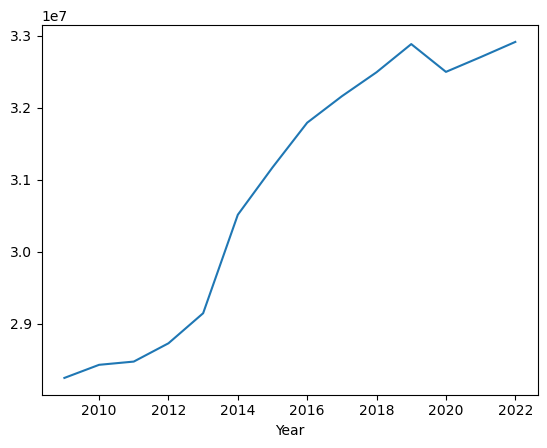

In [ ]:
cars['date'] = pd.to_datetime(dict(year=cars.Year, month=1, day=1))
cars.groupby(['Year']).cars.sum().plot()

Text(0.5, 1.0, 'Car Volume and Year on Year Growth for England')

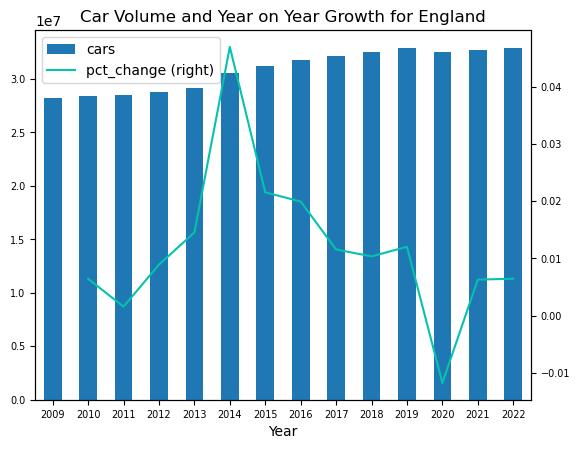

In [ ]:
year = cars[['LSOA11CD','LSOA11NM','Year','cars','Country']] #columns needed for car analysis, to sum by MSOA
year = pd.merge(eng_area[['LSOA11CD','MSOA11CD','MSOA11NM']],year,how='left',on='LSOA11CD')#join car data by LSOA level with MSOA 
year = year[['Country','MSOA11CD','MSOA11NM','Year','cars']]#clean columns 

year = year.groupby(['Country','MSOA11CD','MSOA11NM','Year'])['cars'].agg(['sum']).reset_index() #aggregate by MSOA by Year
year = year.rename({'sum':'cars'},axis=1) #rename sum columns to cars to indicate car volume
year.head(1)

year = cars.groupby(['Year'])['cars'].sum().reset_index() #group car volume by year for England car analysis
year = year.groupby(['Year', 'cars'])['cars'].sum().agg(['pct_change']).reset_index()#add percentage change year on year
year = year.astype({'Year':'int','cars':'int'}) #change data type
#add bar chart with line chart on top for yoy car volume and car volume percentage change analysis for overall England
year[['Year', 'cars']].plot(x='Year',kind='bar', width = 0.5,fontsize=8)
year['pct_change'].plot(secondary_y=True, color='#06C2AC',fontsize=7,legend=True)
plt.title('Car Volume and Year on Year Growth for England')

## Final Car data for Model

In [ ]:
year = 2022 ##Filter 2022 as year for car ownership for this research
cars = cars[cars['Year']==year] #year
cars = cars[cars['LSOA11CD'].str[0]=='E'] #Filter for just England 
cars = cars[cars['Year']==2022] #filter for latest year for car ownership study
cars.head(1)

LSOA11CD             LSOA11NM    Year Quarter   cars Area  Country  \
890  E01000001  City of London 001A  2022.0      Q2  325.0   E0  England   

          date  
890 2022-01-01

## Population
### Population 2018 Density

In [ ]:
pop1 = pd.read_excel('population2022.xlsx',sheet_name='Mid-2020 Population Density') #get file for population density year 2018
pop1 = pop1.iloc[3:,] # delete first three rows
pop1.columns = pop1.iloc[0] #use 4th row as header for columns
pop1 = pop1.iloc[1:,] #delete out row that already is a header column
pop1 = pop1.rename({'LSOA Code':'LSOA11CD'},axis=1) #rename columns
pop1 = pop1[pop1['LSOA11CD'].str[0]=='E'] #choose only LSOA from England
cols = ['Mid-2020 population', 'Area Sq Km','People per Sq Km'] # choose columns
pop1[cols] = pop1[cols].apply(pd.to_numeric, errors='coerce', axis=1) #change column dtypes
#pop1.head() #check data output

In [ ]:
age = pd.read_csv('MSOA-age.csv') #read median age by LSOA, we need median age by MSOA so we need to recalculate ourselves
age = age.rename({'MSOA Code':'MSOA11CD'},axis=1) #calculation of Median Age by MSOA was done by excel using frequency by Age bracket formula

In [ ]:
pop = pop1[['LSOA11CD', 'LSOA Name','Mid-2020 population', 'Area Sq Km']]

In [ ]:
pop.head(1)

3   LSOA11CD        LSOA Name  Mid-2020 population  Area Sq Km
4  E01011949  Hartlepool 009A               1944.0      0.5189

## Household
### 2011 Census

In [ ]:
household = pd.read_csv('Household Size 2011.csv') #household count 
household = household[household['geography code'].str[0]=='E']
household = household.rename({'geography code':'LSOA11CD',
                'Household Size: All categories: Household size; measures: Value':'household',
                'Household Size: 1 person in household; measures: Value':'household1',
                 'Household Size: 2 people in household; measures: Value':'household2',
                 'Household Size: 3 people in household; measures: Value':'household3',
                 'Household Size: 4 people in household; measures: Value':'household4',
                 'Household Size: 5 people in household; measures: Value':'household5',
                 'Household Size: 6 people in household; measures: Value':'household6',
                 'Household Size: 7 people in household; measures: Value':'household7',
                 'Household Size: 8 or more people in household; measures: Value':'household8'},axis=1)
household = household[['LSOA11CD','household','household1', 'household2', 'household3', 'household4', 'household5',
       'household6', 'household7', 'household8']] # filter data from  LSOA file
household['household>=3'] = household['household3']+household['household4']+household['household5']+household['household6']+household['household7']+household['household8'] #Household>=3 calculation
household = household[['LSOA11CD','household', 'household1', 'household2','household>=3']] #only household data needed

## Education
### Census 2011 

In [ ]:
education = pd.read_csv('Education.csv') #add government data for Education
education = education[education['geography code'].str[0]=='E'] #choose only MSOA in England and Filter out Wales
education = education.rename({'geography code':'LSOA11CD',
                'Qualification: All categories: Highest level of qualification; measures: Value':'EducationAll',
                'Qualification: No qualifications; measures: Value':'EducationNo',
                 'Qualification: Level 1 qualifications; measures: Value':'Education1',
                 'Qualification: Level 2 qualifications; measures: Value':'Education2',
                 'Qualification: Apprenticeship; measures: Value':'EducationAppren',
                 'Qualification: Level 3 qualifications; measures: Value':'Education3',
                 'Qualification: Level 4 qualifications and above; measures: Value':'Education4',
                 'Qualification: Other qualifications; measures: Value':'EducationOther'},axis=1)
education = education[['LSOA11CD','EducationAll',
       'EducationNo', 'Education1', 'Education2', 'EducationAppren',
       'Education3', 'Education4', 'EducationOther']]

In [ ]:
education.head(1)

LSOA11CD  EducationAll  EducationNo  Education1  Education2  \
0  E01012334          1884          241         219         306   

   EducationAppren  Education3  Education4  EducationOther  
0               89         230         732              67

## Income
### 2018 Revenue

In [ ]:
income = pd.read_excel('income.xls',sheet_name='Total annual income') #Average annual income by MSOA from Gov UK
income = income.iloc[3:,]
income.columns = income.iloc[0]
income = income.iloc[1:,]
income = income[income['MSOA code'].str[0]=='E'] #Filter England MSOAs
income = income.rename({'MSOA code':'MSOA11CD'},axis=1)
income = income [['MSOA11CD','Total annual income (£)']]
income = income.rename({'Total annual income (£)':'income'},axis=1)
income['income'] = income['income'].apply(pd.to_numeric, errors='coerce')

In [ ]:
income.head(1)

3   MSOA11CD  income
4  E02004297   39800

## Public Transport Accessibility

In [ ]:
path = r'C:\Users\neetm\Desktop\Dissertation\Data\public transport data'
filenames = os.listdir(r'C:\Users\neetm\Desktop\Dissertation\Data\public transport data')
pbx = pd.read_csv(path + f'/'+'Public-transport-journey-times-to-all-FE-establishments.csv')
pbx = pbx.iloc[:,0:2]
for f in filenames:
    pb = pd.read_csv(path+f'/'+f)
    pb.rename(columns={pb.columns[2]: f }, inplace = True)
    pbx = pd.merge(pbx,pb.iloc[:, [0,2]],how='left',on='LSOA11 Code')
pbx.head(1)

LSOA11 Code          LSOA11 Name  \
0   E01000001  City of London 001A   

   Public-transport-journey-times-to-all-FE-establishments.csv  \
0                                              10.35             

   Public-transport-journey-times-to-all-GP-surgeries.csv  \
0                                               3.96        

   Public-transport-journey-times-to-all-hospitals.csv  \
0                                               6.04     

   Public-transport-journey-times-to-all-large-emp-centres.csv  \
0                                               3.59             

   Public-transport-journey-times-to-all-primary-schools.csv  \
0                                               6.12           

   Public-transport-journey-times-to-all-secondary-schools.csv  \
0                                              10.88             

   Public-transport-journey-times-to-all-town-centres.csv  \
0                                              16.89        

   Public-transport-journey-times-to-good-FE-establishments.csv  \
0                                              10.35              

   Public-transport-journey-times-to-good-GP-surgeries.csv  \
0                                               3.96         

   Public-transport-journey-times-to-good-hospitals.csv  \
0                                               6.04      

   Public-transport-journey-times-to-good-primary-schools.csv  \
0                                               6.12            

   Public-transport-journey-times-to-good-secondary-schools.csv  
0                                              10.88

In [ ]:
pop2 = pop1[['LSOA11CD','Mid-2020 population']] #Use population data for weighted average by MSOA
pop2 = pop2.rename({'Mid-2020 population':'LSOA_pop'},axis=1)#Use population data for weighted average by MSOA
pb = pd.merge(pop2,pbx,how='left',left_on='LSOA11CD',right_on='LSOA11 Code') #Join with population data
pb = pb[['LSOA11CD', 'LSOA11 Name','LSOA_pop', 
       'Public-transport-journey-times-to-all-FE-establishments.csv',
       'Public-transport-journey-times-to-all-GP-surgeries.csv',
       'Public-transport-journey-times-to-all-hospitals.csv',
       'Public-transport-journey-times-to-all-large-emp-centres.csv',
       'Public-transport-journey-times-to-all-primary-schools.csv',
       'Public-transport-journey-times-to-all-secondary-schools.csv',
       'Public-transport-journey-times-to-all-town-centres.csv',
       'Public-transport-journey-times-to-good-FE-establishments.csv',
       'Public-transport-journey-times-to-good-GP-surgeries.csv',
       'Public-transport-journey-times-to-good-hospitals.csv',
       'Public-transport-journey-times-to-good-primary-schools.csv',
       'Public-transport-journey-times-to-good-secondary-schools.csv']]

####Create Public Journey Times Measure as proxy of Public Transport Accessibility 
### Multiple Average Journey Times Back to Each population for Total Journey Time By Pop
pb['PB_ALLFE'] = pb['Public-transport-journey-times-to-all-FE-establishments.csv'] * pb['LSOA_pop']
pb['PB_ALLGP'] = pb['Public-transport-journey-times-to-all-GP-surgeries.csv'] * pb['LSOA_pop']
pb['PB_ALLHP'] = pb['Public-transport-journey-times-to-all-hospitals.csv'] * pb['LSOA_pop']
pb['PB_ALLEMP'] = pb['Public-transport-journey-times-to-all-large-emp-centres.csv'] * pb['LSOA_pop']
pb['PB_ALLPS'] = pb['Public-transport-journey-times-to-all-primary-schools.csv'] * pb['LSOA_pop']
pb['PB_ALLSS'] = pb['Public-transport-journey-times-to-all-secondary-schools.csv'] * pb['LSOA_pop']
pb['PB_TC'] = pb['Public-transport-journey-times-to-all-town-centres.csv'] * pb['LSOA_pop']
pb['PB_GFE'] = pb['Public-transport-journey-times-to-good-FE-establishments.csv'] * pb['LSOA_pop']
pb['PB_GGP'] = pb['Public-transport-journey-times-to-good-GP-surgeries.csv'] * pb['LSOA_pop']
pb['PB_GHP'] = pb['Public-transport-journey-times-to-good-hospitals.csv'] * pb['LSOA_pop']
pb['PB_GPS'] = pb['Public-transport-journey-times-to-good-primary-schools.csv'] * pb['LSOA_pop']
pb['PB_GSS'] = pb['Public-transport-journey-times-to-good-secondary-schools.csv'] * pb['LSOA_pop']


####Join with MSOA data
pb_msoa = eng_area[['LSOA11CD','MSOA11CD', 'MSOA21CD']]
pb = pd.merge(pb_msoa,pb,how='left',on = 'LSOA11CD')
pbavg = pb[['MSOA11CD', 'MSOA21CD', 'LSOA_pop',
       'PB_ALLFE', 'PB_ALLGP', 'PB_ALLHP', 'PB_ALLEMP', 'PB_ALLPS', 'PB_ALLSS',
       'PB_TC', 'PB_GFE', 'PB_GGP', 'PB_GHP', 'PB_GPS', 'PB_GSS']]
pbavg = pbavg.groupby(by=["MSOA11CD"]).sum().reset_index() #sum all data to MSOA level including population by LSOA

### Weighted Average by Population for Each MSOA
pbavg['PB_ALLFE'] = pbavg['PB_ALLFE']/pbavg['LSOA_pop'] #divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_ALLGP'] = pbavg['PB_ALLGP']/pbavg['LSOA_pop'] #divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_ALLHP'] = pbavg['PB_ALLHP']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_ALLEMP'] = pbavg['PB_ALLEMP']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_ALLPS'] = pbavg['PB_ALLPS']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_ALLSS'] = pbavg['PB_ALLSS']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_TC'] = pbavg['PB_TC']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_GFE'] = pbavg['PB_GFE']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_GGP'] = pbavg['PB_GGP']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_GHP'] = pbavg['PB_GHP']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_GPS'] = pbavg['PB_GPS']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)
pbavg['PB_GSS'] = pbavg['PB_GSS']/pbavg['LSOA_pop']#divide by population by MSOA (LSOA pop was aggregated to MSOA)

public = pbavg[['MSOA11CD','PB_ALLFE', 'PB_ALLGP', 'PB_ALLHP',
       'PB_ALLEMP', 'PB_ALLPS', 'PB_ALLSS', 'PB_TC', 'PB_GFE', 'PB_GGP',
       'PB_GHP', 'PB_GPS', 'PB_GSS']]

In [ ]:
public.head(1)

MSOA11CD  PB_ALLFE  PB_ALLGP  PB_ALLHP  PB_ALLEMP  PB_ALLPS  PB_ALLSS  \
0  E02000001   10.2763    6.6065    8.9253     4.4551    6.4693   10.5306   

     PB_TC   PB_GFE  PB_GGP  PB_GHP  PB_GPS   PB_GSS  
0  16.2894  10.9154  6.6065  9.8408  6.4693  10.9191

## Urban Form:Median

In [ ]:
urban_median = pd.read_csv('urbanmedian.csv') #Momepy Data for Urban Form in Median, details of momepy data in another jupyter notebook
urban_median = urban_median.drop({'Unnamed: 0','geometry'},axis=1)
urban_median = urban_median.rename({'msoa11cd':'MSOA11CD'},axis=1)
urban_median = urban_median[urban_median['MSOA11CD'].str[0]=='E'] #Filtering only England
urban_median = urban_median.drop(['sdbCoA','objectid', 'msoa11nm', 'msoa11nmw', 'st_areasha', 'st_lengths'], axis=1) #dropped columns unused, sdbCoA had 0 values so removed
#drop not needed columns

In [ ]:
urban_median.describe()

sdbAre     sdbHei     sdbPer     sdbVol     ssbFoF     ssbVFR  \
count  6791.0000  6791.0000  6791.0000  6791.0000  6791.0000  6791.0000   
mean     60.4223     7.6969    34.3100   468.7071     1.0590     1.7550   
std      10.4045     1.3168     3.3845   133.3931     0.1452     0.1354   
min      31.6719     2.7000    23.3780   111.2176     0.6557     1.2588   
25%      52.7178     7.0000    32.0845   398.2093     0.9531     1.6642   
50%      58.9355     7.6000    34.1377   435.0748     1.0325     1.7403   
75%      66.2845     8.2000    36.1821   491.9631     1.1455     1.8402   
max     136.2815    23.1000    58.2835  2974.2464     1.7839     2.4657   

          ssbCCo     ssbCor     ssbSqu     ssbERI  ...     stbSAl  \
count  6791.0000  6791.0000  6791.0000  6791.0000  ...  6791.0000   
mean      0.5156     5.4990     0.5377     0.9720  ...     5.9143   
std       0.0466     0.9993     0.4201     0.0215  ...     2.6032   
min       0.2518     4.0000     0.0075     0.8649  ...     0.2973   
25%       0.5093     4.0000     0.4006     0.9564  ...     3.9589   
50%       0.5256     6.0000     0.4868     0.9721  ...     6.1751   
75%       0.5390     6.0000     0.6110     0.9944  ...     7.9550   
max       0.6258    10.0000    13.0068     1.0000  ...    21.4417   

            ldbPWL     mtbSWR       sddAre       sdsAre     sisBpM     misCel  \
count    6791.0000  6791.0000    6791.0000    6791.0000  6791.0000  6791.0000   
mean   215554.8960     0.9974   23089.1306   37110.8532     0.1831    76.1102   
std    150190.6098     0.0080   34983.6121   65441.3674     0.0561    25.6283   
min      3882.0328     0.9107    1492.1129    3023.5027     0.0288    22.5164   
25%    106575.6599     1.0000    9140.6566   11680.1558     0.1546    58.0745   
50%    168434.2749     1.0000   11797.6267   15026.1154     0.1869    71.0000   
75%    272902.9595     1.0000   16697.3343   22123.6560     0.2142    87.0320   
max    871384.2142     1.0000  344525.0764  735664.6389     0.9252   267.0000   

           mdsAre     lisCel      ldsAre  
count  6.7910e+03  6791.0000  6.7910e+03  
mean   1.3420e+05   270.1636  5.7731e+05  
std    2.3665e+05   116.9417  1.0122e+06  
min    1.2051e+04    84.7823  4.6341e+04  
25%    4.3156e+04   193.0000  1.8567e+05  
50%    5.3990e+04   242.0000  2.3481e+05  
75%    7.8707e+04   312.0000  3.4544e+05  
max    2.9123e+06  1430.0000  1.2204e+07  

[8 rows x 68 columns]

In [ ]:
urban_median[urban_median['MSOA11CD']=='E02000001']

MSOA11CD    sdbAre  sdbHei   sdbPer     sdbVol  ssbFoF  ssbVFR  ssbCCo  \
0  E02000001  136.2815    23.1  58.2835  2974.2464     0.7  2.3904  0.4496   

   ssbCor  ssbSqu  ...  stbSAl      ldbPWL  mtbSWR     sddAre      sdsAre  \
0     6.0  7.6746  ...   5.158  38022.0827     1.0  5743.8269  12002.0707   

   sisBpM  misCel      mdsAre    lisCel       ldsAre  
0  0.1134    29.0  49620.3521  111.1228  227273.3756  

[1 rows x 69 columns]

## Joining Dataset by LSOA Level

In [ ]:
#join eng geopandas map data with car ownership
df_all = pd.merge(eng_area,cars[['LSOA11CD','cars']],how='left',left_on = 'LSOA11CD',right_on ='LSOA11CD')

#join eng geopandas map data with population data

df_all = pd.merge(df_all,pop[['LSOA11CD','Mid-2020 population', 'Area Sq Km']],
         how='left',left_on = 'LSOA11CD',right_on ='LSOA11CD')

#join eng geopandas map data with household data

df_all = pd.merge(df_all,household[['LSOA11CD','household','household1', 'household2','household>=3']],
         how='left',left_on = 'LSOA11CD',right_on ='LSOA11CD')

#join eng geopandas map data with education data
df_all = pd.merge(df_all,education,
         how='left',left_on = 'LSOA11CD',right_on ='LSOA11CD')

##  Final Data Join by MSOA

In [ ]:
msoa_min = df_all.groupby('MSOA11CD').sum().reset_index() #sum all types of population count from LSOA into MSOA (population sum)
msoa_area = eng_area[['MSOA11CD', 'MSOA11NM','MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM', 'CTRY21CD', 'CTRY21NM']]
msoa_area = msoa_area.drop_duplicates(subset=['MSOA11CD', 'MSOA11NM','MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM', 'CTRY21CD', 'CTRY21NM'], keep='first')

df = pd.merge(msoa_area,msoa_min,how='left',on='MSOA11CD')
df = pd.merge(df,income,how='left',on='MSOA11CD') #join with income level by MSOA
df = pd.merge(df,urban_median,how='left',on='MSOA11CD') #join with with urban form data by median with MSOA

In [ ]:
df.columns

Index(['MSOA11CD', 'MSOA11NM', 'MSOA21CD', 'MSOA21NM', 'LAD22CD', 'LAD22NM',
       'CTRY21CD', 'CTRY21NM', 'cars', 'Mid-2020 population', 'Area Sq Km',
       'household', 'household1', 'household2', 'household>=3', 'EducationAll',
       'EducationNo', 'Education1', 'Education2', 'EducationAppren',
       'Education3', 'Education4', 'EducationOther', 'income', 'sdbAre',
       'sdbHei', 'sdbPer', 'sdbVol', 'ssbFoF', 'ssbVFR', 'ssbCCo', 'ssbCor',
       'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'stbOri', 'sdcLAL',
       'sdcAre', 'sicFAR', 'sscCCo', 'sscERI', 'stcOri', 'sicCAR', 'stbCeA',
       'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE', 'ltbIBD', 'ltcRea',
       'ltcAre', 'sdsSPW', 'sdsSPH', 'sdsSPO', 'sdsSWD', 'sdsSHD', 'sdsSPR',
       'sdsLen', 'sssLin', 'ldsMSL', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W',
       'linPDE', 'lcnClo', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID',
       'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB',
       'l

## data map with Map MSOA

In [ ]:
#Map with MSOA map

df_msoa = pd.merge(MSOA,df,how='left',on='MSOA11CD')
df_msoa = pd.merge(df_msoa,age,how='left',on='MSOA11CD') #Map with median age data available at MSOA
df_msoa = pd.merge(df_msoa,public,how='left',on="MSOA11CD") #Map with public transport accessibility dataset

#pd.options.display.max_colwidth = 20 #show entire columns
#df_msoa.head(1)

In [ ]:
df_msoa.head(1)

OBJECTID   MSOA11CD          MSOA11NM_x   BNG_E   BNG_N   LONG_      LAT  \
0         1  E02000001  City of London 001  532384  181355 -0.0935  51.5156   

   Shape_Leng  Shape__Area  Shape__Length  ... PB_ALLHP PB_ALLEMP PB_ALLPS  \
0   9651.2211   3.1515e+06      9651.2211  ...   8.9253    4.4551   6.4693   

  PB_ALLSS    PB_TC   PB_GFE  PB_GGP  PB_GHP  PB_GPS   PB_GSS  
0  10.5306  16.2894  10.9154  6.6065  9.8408  6.4693  10.9191  

[1 rows x 116 columns]

In [ ]:
#features = pd.DataFrame(df_msoa.columns.tolist())

## Metrics created

In [ ]:
## Create metrics car by population and population density for use in the model
df_msoa['popdensity'] = round(df_msoa['Mid-2020 population']/df_msoa['Area Sq Km'],2)
df_msoa['car_by_pop'] = round(df_msoa['cars']/df_msoa['Mid-2020 population'],2)
df_msoa['car_by_area'] = round(df_msoa['cars']/df_msoa['Area Sq Km'],2)
df_msoa = df_msoa.rename({'Median':'Age-Median'},axis=1)

In [ ]:
df_msoa.head(1)

OBJECTID   MSOA11CD          MSOA11NM_x   BNG_E   BNG_N   LONG_      LAT  \
0         1  E02000001  City of London 001  532384  181355 -0.0935  51.5156   

   Shape_Leng  Shape__Area  Shape__Length  ... PB_ALLSS    PB_TC   PB_GFE  \
0   9651.2211   3.1515e+06      9651.2211  ...  10.5306  16.2894  10.9154   

   PB_GGP  PB_GHP  PB_GPS   PB_GSS popdensity  car_by_pop  car_by_area  
0  6.6065  9.8408  6.4693  10.9191    3774.59        0.23       852.72  

[1 rows x 119 columns]

In [ ]:
#drop columns not needed
df_msoa = df_msoa.drop(['BNG_E',
 'BNG_N','Shape_Leng',
 'Shape__Area',
 'Shape__Length',
'MSOA11NM_y',
 'MSOA21CD',
 'MSOA21NM',
 'LAD22CD',
 'LAD22NM',
 'CTRY21CD',
 'CTRY21NM'],axis=1) 

## Final Deal with Null and Nans

In [ ]:
df_msoa[df_msoa.isna().any(axis=1)]

#E02000001 City of London 001
#E02006781	Isles of Scilly 001
#df_msoa['sdbCoA'] check data from column with all 0 values then removed
df_msoa = df_msoa[~df_msoa.isna().any(axis=1)]
#df_msoa = df_msoa.drop(['sdbCoA'],axis=1)

df_msoa[df_msoa.isna().any(axis=1)] #removed two MSOAs that have Urban Form NA values, need to ask Professor Alessandro
#Dask crashes

Empty GeoDataFrame
Columns: [OBJECTID, MSOA11CD, MSOA11NM_x, LONG_, LAT, geometry, cars, Mid-2020 population, Area Sq Km, household, household1, household2, household>=3, EducationAll, EducationNo, Education1, Education2, EducationAppren, Education3, Education4, EducationOther, income, sdbAre, sdbHei, sdbPer, sdbVol, ssbFoF, ssbVFR, ssbCCo, ssbCor, ssbSqu, ssbERI, ssbElo, ssbCCM, ssbCCD, stbOri, sdcLAL, sdcAre, sicFAR, sscCCo, sscERI, stcOri, sicCAR, stbCeA, mtbAli, mtbNDi, mtcWNe, mdcAre, ltcWRE, ltbIBD, ltcRea, ltcAre, sdsSPW, sdsSPH, sdsSPO, sdsSWD, sdsSHD, sdsSPR, sdsLen, sssLin, ldsMSL, mtdDeg, lcdMes, linP3W, linP4W, linPDE, lcnClo, ldsCDL, xcnSCl, mtdMDi, lddNDe, linWID, ldeAre, ldePer, lseCCo, lseERI, lseCWA, lteOri, lteWNB, lieWCe, stbSAl, ldbPWL, mtbSWR, sddAre, sdsAre, sisBpM, misCel, mdsAre, lisCel, ldsAre, MSOA Name, Age-Median, PB_ALLFE, PB_ALLGP, PB_ALLHP, PB_ALLEMP, PB_ALLPS, PB_ALLSS, PB_TC, PB_GFE, ...]
Index: []

[0 rows x 107 columns]

## Data Exploration and Outliers

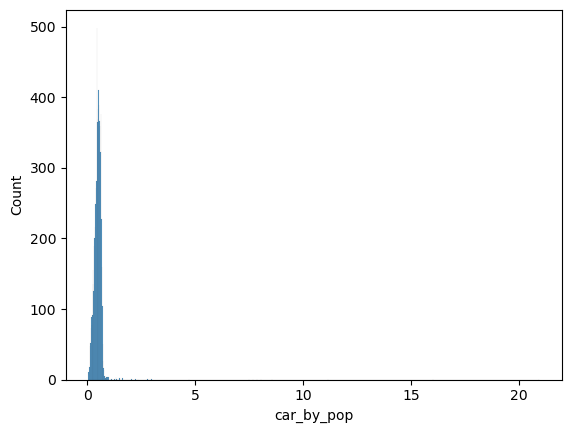

In [ ]:
import seaborn as sns
sns.histplot(df_msoa['car_by_pop'])
import matplotlib.pyplot as plt
plt.show()

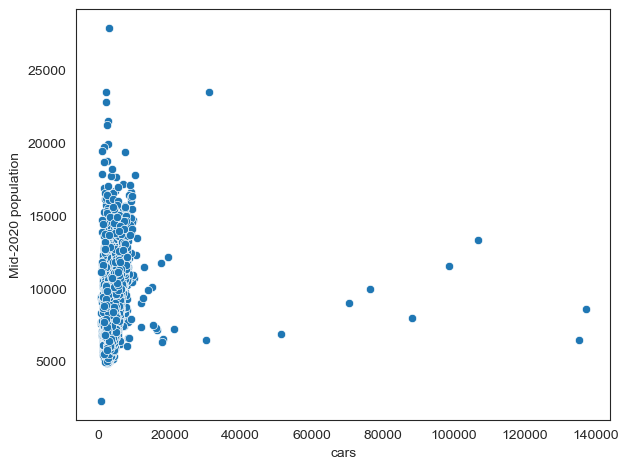

In [ ]:
sns.set_style("white")
from scipy import stats
sns.scatterplot(data=df_msoa, x ='cars', y ='Mid-2020 population')
stats.pearsonr(df_msoa['cars'], df_msoa['Mid-2020 population'])
plt.tight_layout()
plt.show()

PearsonRResult(statistic=0.11294645877365728, pvalue=1.0022144277145983e-20)

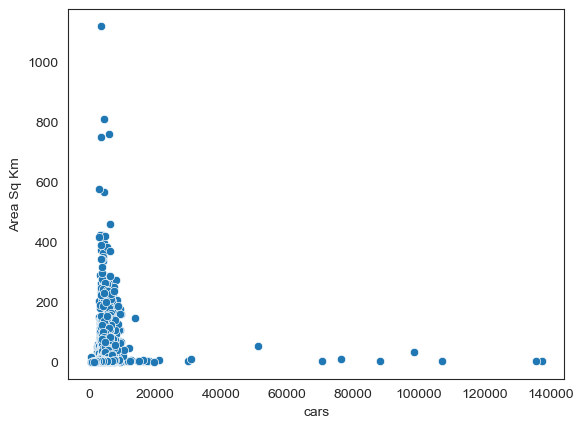

In [ ]:
sns.scatterplot(data=df_msoa, x ='cars', y ='Area Sq Km')
stats.pearsonr(df_msoa['cars'], df_msoa['Area Sq Km'])

<AxesSubplot: xlabel='car_by_pop', ylabel='Area Sq Km'>

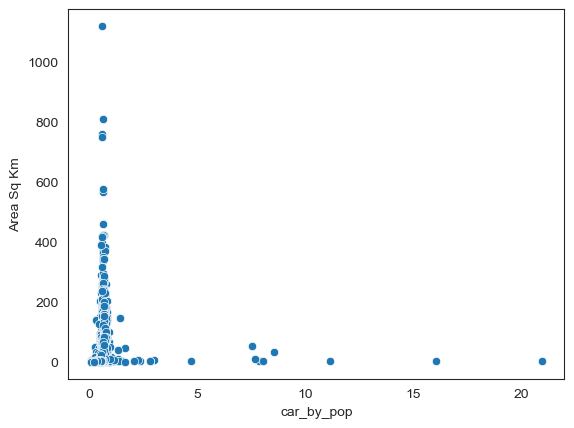

In [ ]:
sns.scatterplot(data=df_msoa, x ='car_by_pop', y ='Area Sq Km') #important

## Outliers
Dealing with Outliers by Imputation, replacing with median values

Like imputation of missing values, we can also impute outliers. We can use mean, median, zero value in this methods. Since we imputing there is no loss of data. Here median is appropriate because it is not affected by outliers.

In [ ]:
df_msoa = df_msoa.rename({'MSOA11NM_x':'MSOA11NM'})

Text(0.5, 1.0, 'Boxplot before dealing with Outliers')

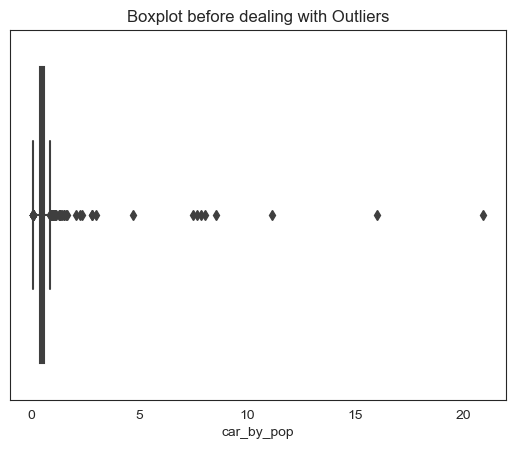

In [ ]:
sns.boxplot(x=df_msoa["car_by_pop"])
plt.title('Boxplot before dealing with Outliers')

In [ ]:
lower_limit = df_msoa["car_by_pop"].quantile(0.01)  
upper_limit = df_msoa["car_by_pop"].quantile(0.99)

print(lower_limit)
print(upper_limit)

0.13
0.77


Text(0.5, 1.0, 'Displot before dealing with Outliers')

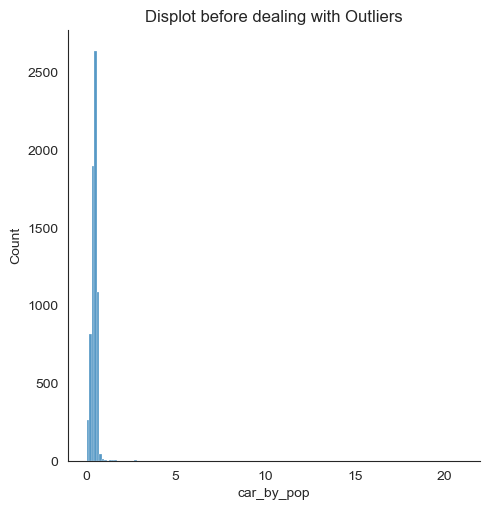

In [ ]:
sns.displot(x=df_msoa["car_by_pop"],bins=150)
plt.title('Displot before dealing with Outliers')

In [ ]:
df_msoa["car_by_pop"] = np.where(df_msoa["car_by_pop"]> upper_limit, upper_limit,
                        np.where(df_msoa["car_by_pop"]< lower_limit, lower_limit,
                        df_msoa["car_by_pop"]))

Text(0.5, 1.0, 'Displot After Dealing with Outliers')

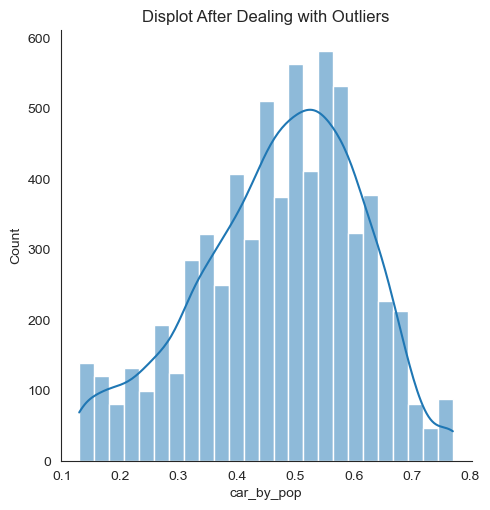

In [ ]:
sns.displot(df_msoa['car_by_pop'], bins=25, kde=True);
plt.title('Displot After Dealing with Outliers')

Text(0.5, 1.0, 'Boxplot After Dealing with Outliers')

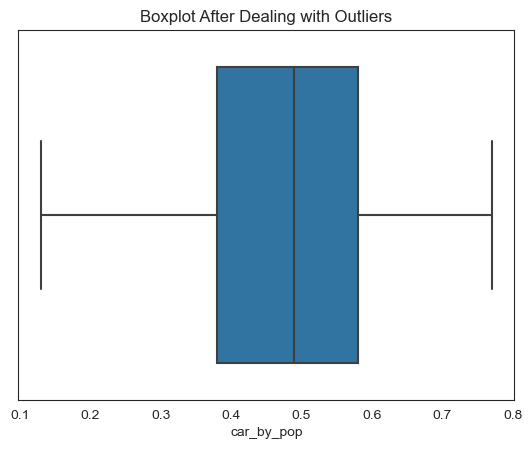

In [ ]:
sns.boxplot(x=df_msoa["car_by_pop"])
plt.title('Boxplot After Dealing with Outliers')

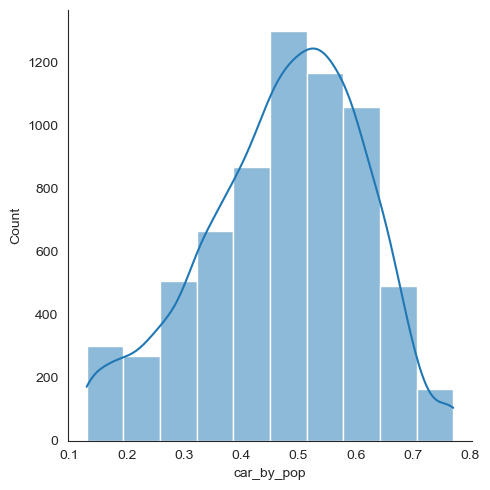

In [ ]:
sns.displot(df_msoa['car_by_pop'], bins=10, kde=True);

Text(0.5, 1.0, 'Car Dependency By Population')

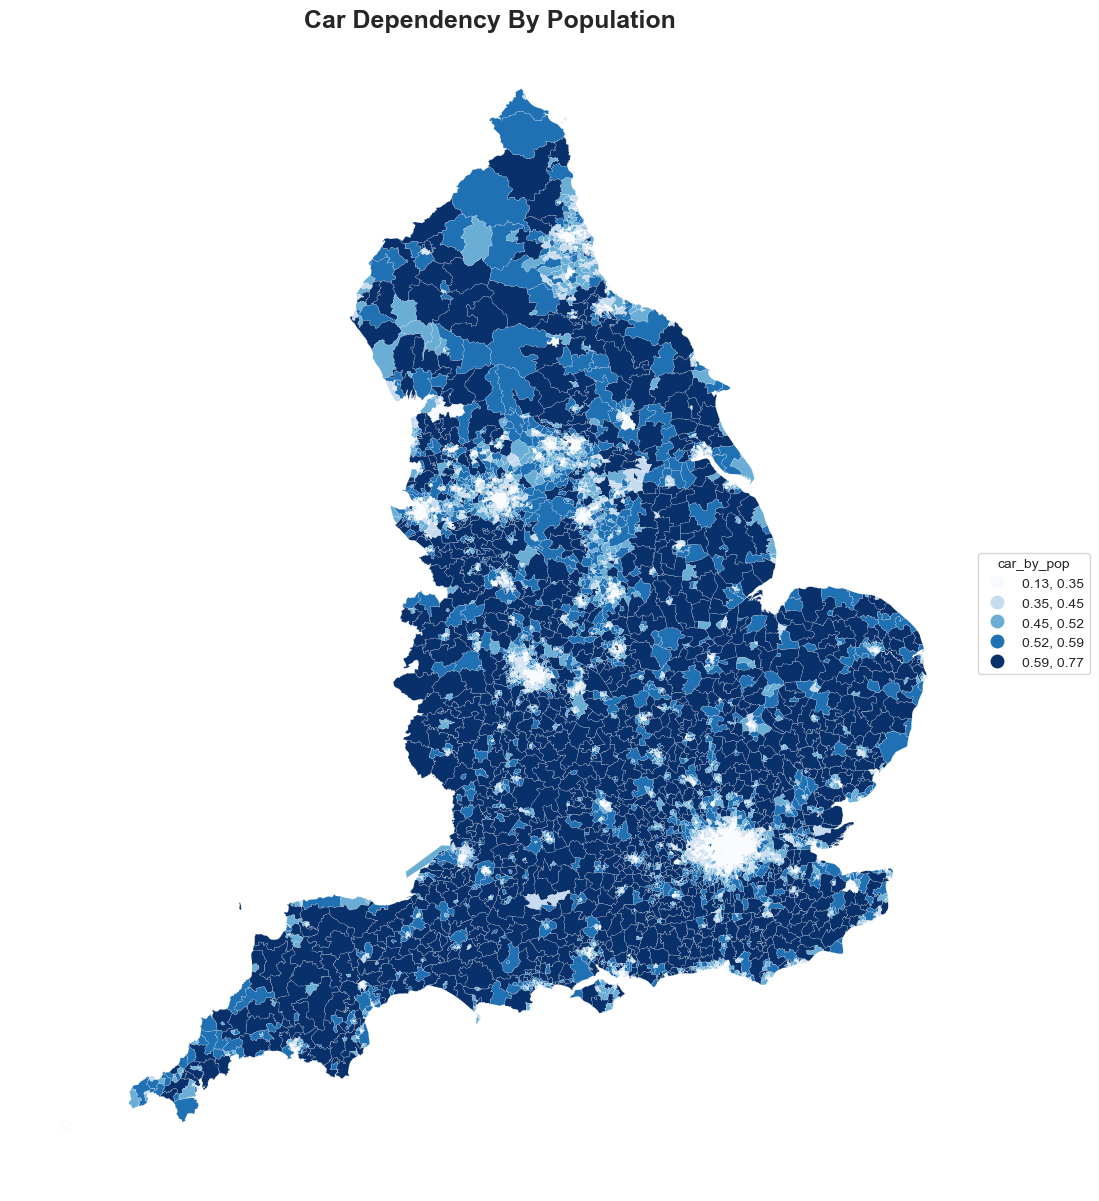

In [ ]:
df_msoa= gpd.GeoDataFrame(df_msoa, geometry='geometry')
car_plot = df_msoa.plot(column = 'car_by_pop', #Assign numerical data column
                      legend = True, #Decide to show legend or not
             legend_kwds={'loc': 'center left','title':'car_by_pop', 'bbox_to_anchor':(1,0.5),'fmt':"{:.2f}"},
                      figsize = [15,15],
                      scheme='quantiles', k=5,linewidth=0.1,cmap = 'Blues')
car_plot.axis('off')
car_plot.set_title('Car Dependency By Population', fontdict={'fontsize': 18, 'fontweight': 'bold'})

In [ ]:
#display(df_msoa.describe().transpose()[['count','mean','std']])

In [ ]:
df_msoa['car_by_pop'].describe()

count    6791.0000
mean        0.4724
std         0.1398
min         0.1300
25%         0.3800
50%         0.4900
75%         0.5800
max         0.7700
Name: car_by_pop, dtype: float64

In [ ]:
df_msoa = pd.DataFrame(df_msoa)